In [1]:
import numpy as np
import time
from collections import namedtuple
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import qiskit as q
import qiskit.tools.jupyter
from qiskit.pulse import pulse_lib as _  # only want to call pulse_lib as q.pulse.pulse_lib

In [3]:
import pulse_compiler_helper_fns

In [4]:
q.IBMQ.load_account() # Load account from disk

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [5]:
#provider = q.IBMQ.get_provider(group='qiskit-terra', project='pulse-testing')
#backend = provider.get_backend('alt_almaden')
from qiskit.test.mock import FakeAlmaden
backend = FakeAlmaden()
defaults = backend.defaults()
circ_inst_map = defaults.circuit_instruction_map
measure = circ_inst_map.get('measure', qubits=backend.configuration().meas_map[0])

In [6]:
schedules = []

In [7]:
circuit = q.QuantumCircuit(2)
circuit.x(0)
circuit.cx(0, 1)
circuit.x(0);

In [8]:
schedules = []

transpiled_circuit = q.transpile(circuit, backend, optimization_level=1)
schedule = q.schedule(transpiled_circuit, backend=backend, inst_map=circ_inst_map)
schedule |= measure << schedule.duration
schedules.append(schedule)

with qiskit.PulseBackedOptimizationContext():
    from qiskit.transpiler import PassManager
    from qiskit.transpiler.passes import CommutationAnalysis, CommutativeCancellation, MatchZZInteraction
    pm = PassManager()
    pm.append([CommutationAnalysis(), MatchZZInteraction()])
    matched_circuit = pm.run(circuit)
    decomposed_circuit = matched_circuit.decompose()
    pulse_compiler_helper_fns.update_basis_gates_and_circ_inst_map(decomposed_circuit, backend, circ_inst_map)
    transpiled_circuit = q.transpile(decomposed_circuit, backend, optimization_level=1)
    schedule = q.schedule(transpiled_circuit, backend=backend, inst_map=circ_inst_map)
    schedule |= measure << schedule.duration
    schedules.append(schedule)

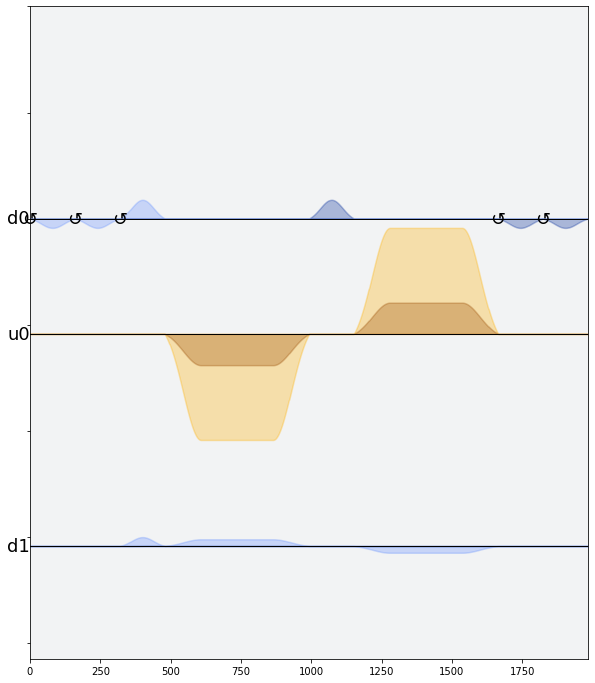

In [9]:
schedules[0].draw(
    channels=[backend.configuration().drive(0), backend.configuration().control(0), backend.configuration().drive(1)],
    table=False)

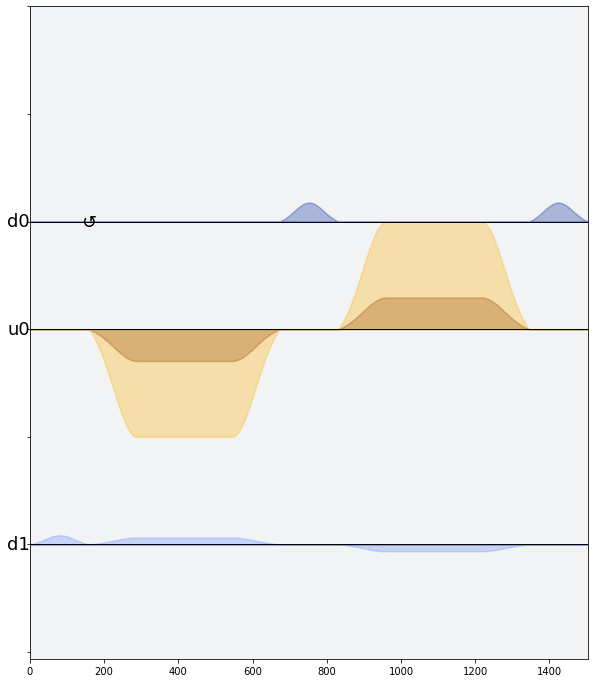

In [10]:
schedules[1].draw(
    channels=[backend.configuration().drive(0), backend.configuration().control(0), backend.configuration().drive(1)],
    table=False)

In [ ]:
shots = 8000
job = q.execute(schedules, backend=backend, shots=shots)
print('job is %s' % job.job_id())

In [ ]:
job.status()

In [ ]:
result = job.result()

In [ ]:
from qiskit.ignis.verification.tomography.data import marginal_counts

In [ ]:
counts_list = []
counts = marginal_counts(result.get_counts(0), meas_qubits=[0,1])    
counts_list.append(counts)
print('Standard way: %s' % counts)

counts = marginal_counts(result.get_counts(1), meas_qubits=[0,1])    
counts_list.append(counts)
print('Our cross-gate pulse cancellation way: %s' % counts)

In [ ]:
print(counts_list)

In [ ]:
counts_list = [{'00': 740, '01': 192, '10': 6968, '11': 100}, {'00': 759, '01': 164, '10': 6984, '11': 93}]

In [ ]:
from qiskit.visualization import plot_histogram
fig = plot_histogram(counts_list, title='Open CNOT Experimental Results', figsize=(7, 3), legend=['Standard', 'Optimized'], )
fig.savefig('Figures/open_cnot_histogram.svg', bbox_inches='tight', pad_inches=1)
fig